In [1]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [2]:
import os
import ast
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]

path = "data/token_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset["train"] = dataset["train"].remove_columns("spacy_ner_tags")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 435710
    })
})

In [3]:
# Evaluate tokens and ner_tags as lists
dataset = dataset.map(lambda line: {'tokens': ast.literal_eval(line['tokens'])})
dataset = dataset.map(lambda line: {'ner_tags': ast.literal_eval(line['ner_tags'])})

Map:   0%|          | 0/435710 [00:00<?, ? examples/s]

Map:   0%|          | 0/435710 [00:00<?, ? examples/s]

In [4]:
# Cast ner_tags to ClassLabel with all labels present in ner_tags
from datasets import ClassLabel, Sequence

dataset = dataset.cast_column("ner_tags", Sequence(feature=ClassLabel(num_classes=len(label_list), names=label_list)))

Casting the dataset:   0%|          | 0/435710 [00:00<?, ? examples/s]

In [5]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR'], id=None), length=-1, id=None)}

In [6]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [7]:
show_random_elements(dataset["train"])

,text,tokens,ner_tags
0,Comment me rendre à l'aéroport d'AUTUN depuis l'aéroport de MOYEN ?,"[Comment, me, rendre, à, l', aéroport, d', AUTUN, depuis, l', aéroport, de, MOYEN, , .]","[O, O, O, O, O, O, O, B-ARR, O, O, O, O, B-DEP, O, O]"
1,Trouve un itinéraire pour aller de Blois à Paray-Le-Monial.,"[Trouve, un, itinéraire, pour, aller, de, Blois, à, Paray-, Le-, Monial, .]","[O, O, O, O, O, O, B-DEP, O, B-ARR, I-ARR, I-ARR, O]"
2,Depuis vitre vers BITCHE,"[Depuis, vitre, vers, BITCHE]","[O, B-DEP, O, B-ARR]"
3,Établis un chemin sûr de MAURIAC jusqu'à mans (le ) pour que je puisse rejoindre Haddou,"[Établis, un, chemin, sûr, de, MAURIAC, jusqu', à, mans, le, pour, que, je, puisse, rejoindre, Haddou]","[O, O, O, O, O, B-DEP, O, O, B-ARR, I-ARR, O, O, O, O, O, O]"
4,Recherche le chemin entre CAEN et lutzelbourg,"[Recherche, le, chemin, entre, CAEN, et, lutzelbourg]","[O, O, O, O, B-DEP, O, B-ARR]"
5,Comment aller à l'hopital de Vézelise depuis l'hopital de gannat ?,"[Comment, aller, à, l', hopital, de, Vézelise, depuis, l', hopital, de, gannat, , .]","[O, O, O, O, O, O, B-ARR, O, O, O, O, B-DEP, O, O]"
6,Partez pour l'aéroport de Lesparre Médoc en partant de SOSPEL.,"[Partez, pour, l', aéroport, de, Lesparre, Médoc, en, partant, de, SOSPEL, .]","[O, O, O, O, O, B-ARR, I-ARR, O, O, O, B-DEP, O]"
7,"Je souhaiterais me déplacer de SAINT MARCELLIN à sarrebourg lp messmer, si c'est réalisable","[Je, souhaiterais, me, déplacer, de, SAINT, MARCELLIN, à, sarrebourg, lp, messmer,, si, c', est, réalisable]","[O, O, O, O, O, B-DEP, I-DEP, O, B-ARR, I-ARR, I-ARR, O, O, O, O]"
8,Je désire aller à Frasne depuis st pol sur ternoise. Peux-tu aider,"[Je, désire, aller, à, Frasne, depuis, st, pol, sur, ternoise., Peux-, tu, aider]","[O, O, O, O, B-ARR, O, B-DEP, I-DEP, I-DEP, I-DEP, O, O, O]"
9,Trouve-moi le chemin le plus rapide vers Ales depuis st louis 57 incliné pour arriver chez Gisèle.,"[Trouve-, moi, le, chemin, le, plus, rapide, vers, Ales, depuis, st, louis, 57, incliné, pour, arriver, chez, Gisèle, .]","[O, O, O, O, O, O, O, O, B-ARR, O, B-DEP, I-DEP, I-DEP, I-DEP, O, O, O, O, O]"


In [8]:
# count number of each label in ner_tags
from collections import Counter

tag_counts = Counter()
for tags in dataset['train']['ner_tags']:
    tag_counts.update(tags)
    
tag_counts = {label_list[key]: value for key, value in tag_counts.items()}
tag_counts

{'O': 4639443,
 'B-ARR': 393980,
 'I-ARR': 359761,
 'B-DEP': 393980,
 'I-DEP': 369002}

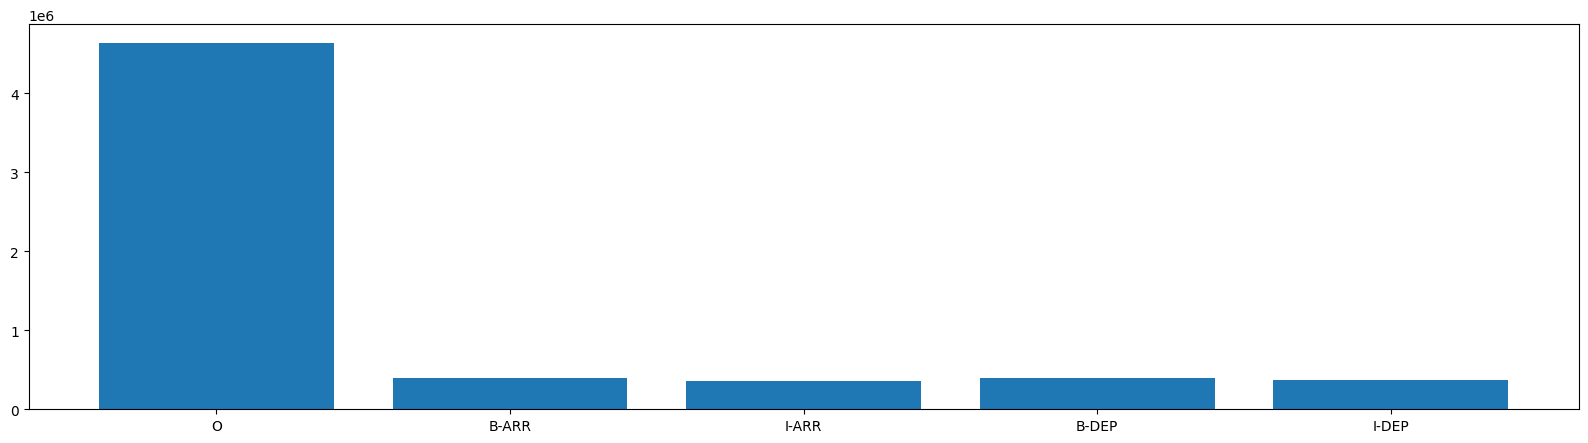

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.show()

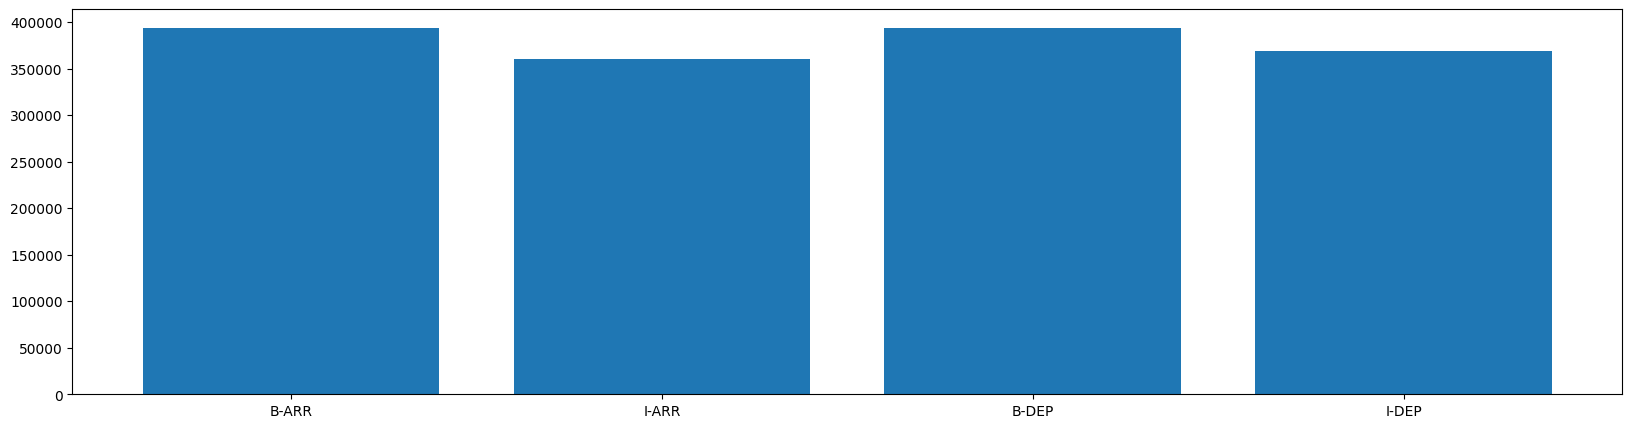

In [10]:
del tag_counts['O']
plt.figure(figsize=(20, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.show()

In [11]:
# Shuffle train dataset, and pick 30% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.7)['train']

# Split so we have 55% of train, rest is shared between test and valid
train_test_valid = train_data.train_test_split(test_size=0.25)
test_valid = train_test_valid['test'].train_test_split(test_size=0.7)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 98034
    })
    test: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 22876
    })
    valid: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 9803
    })
})

In [12]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "camembert-base"

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [15]:
example = dataset["train"][0]

In [16]:
example["tokens"]

['Comment',
 'puis-',
 'je',
 'me',
 'rendre',
 'à',
 'YZEURE',
 'en',
 'partant',
 'de',
 'la',
 'ville',
 'de',
 'SAUMUR',
 '',
 '.']

In [17]:
tokenizer(example["tokens"], is_split_into_words=True)

{'input_ids': [5, 841, 264, 26, 50, 103, 716, 15, 1057, 20087, 15658, 22, 8494, 8, 13, 285, 8, 4730, 6875, 4331, 21, 9, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['<s>',
 '▁Comment',
 '▁puis',
 '-',
 '▁je',
 '▁me',
 '▁rendre',
 '▁à',
 '▁Y',
 'ZE',
 'URE',
 '▁en',
 '▁partant',
 '▁de',
 '▁la',
 '▁ville',
 '▁de',
 '▁SA',
 'UM',
 'UR',
 '▁',
 '.',
 '</s>']

In [19]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

23 23


In [20]:
label_all_tokens = True

In [21]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [22]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/98034 [00:00<?, ? examples/s]

Map:   0%|          | 0/22876 [00:00<?, ? examples/s]

Map:   0%|          | 0/9803 [00:00<?, ? examples/s]

In [23]:
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

In [24]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
batch_size = 16
epochs = 3
metric_name = "f1"

In [26]:
args = TrainingArguments(
    f"models/camembert-finetuned-token-classification-ner-trip",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    #push_to_hub=True,
)

In [27]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
from datasets import load_metric

metric = load_metric("seqeval")

C:\Users\Eliott Clavier\AppData\Local\Temp\ipykernel_31136\3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [29]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'ARR': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'DEP': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [30]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    y_pred = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    y_true = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=y_pred, references=y_true)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.003500,0.001204,0.999877,0.999979,0.999928,0.999962
2,0.000700,0.000816,0.999712,0.999589,0.999651,0.999862
3,0.000300,0.000580,0.999815,0.999856,0.999836,0.999933


Checkpoint destination directory models/camembert-finetuned-token-classification-ner-trip\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/camembert-finetuned-token-classification-ner-trip\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/camembert-finetuned-token-classification-ner-trip\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=18384, training_loss=0.017647529396190395, metrics={'train_runtime': 1417.2834, 'train_samples_per_second': 207.511, 'train_steps_per_second': 12.971, 'total_flos': 5583248609785080.0, 'train_loss': 0.017647529396190395, 'epoch': 3.0})

In [33]:
trainer.save_model("models/camembert-finetuned-token-classification-ner-trip")

In [34]:
train_metrics = trainer.evaluate(tokenized_datasets["train"])
validation_metrics = trainer.evaluate(tokenized_datasets["valid"])

In [35]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
y_pred = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
y_true = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=y_pred, references=y_true)
results

{'ARR': {'precision': 0.9998593530239099,
  'recall': 0.9999120910033933,
  'f1': 0.9998857213182484,
  'number': 56877},
 'DEP': {'precision': 0.999860152084608,
  'recall': 0.9999475524475524,
  'f1': 0.9999038503561908,
  'number': 57200},
 'overall_precision': 0.9998597536924223,
 'overall_recall': 0.9999298719286096,
 'overall_f1': 0.9998948115812449,
 'overall_accuracy': 0.999953177325611}

# Matrice de confusion

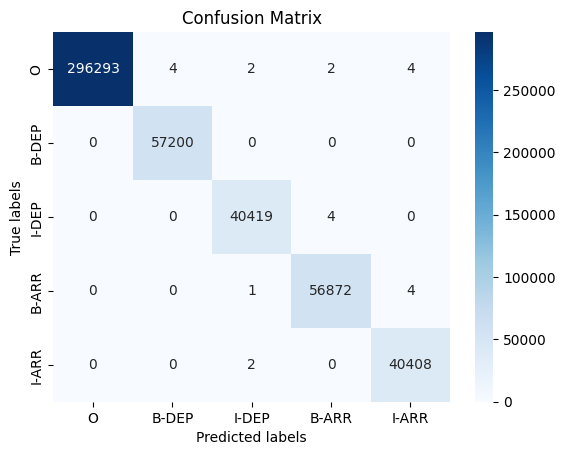

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

flat_y_true = [item for sublist in y_true for item in sublist]
flat_y_pred = [item for sublist in y_pred for item in sublist]

cm = confusion_matrix(flat_y_true, flat_y_pred, labels=label_list)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Matrice de confusion sans le label O

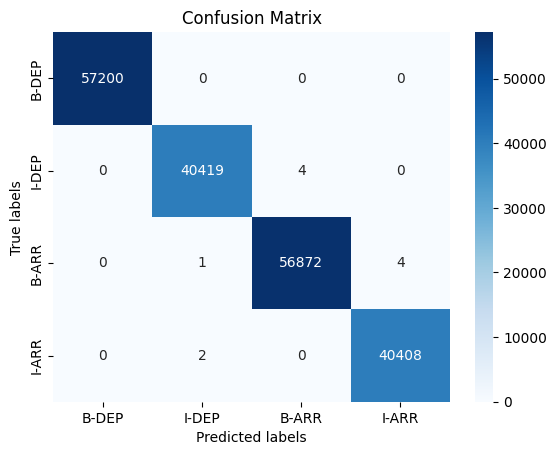

In [37]:
def filter_label(label_to_exclude, true_labels, predicted_labels):
    filtered_true = [true for true, pred in zip(true_labels, predicted_labels) if pred != label_to_exclude]
    filtered_pred = [pred for pred in predicted_labels if pred != label_to_exclude]
    return filtered_true, filtered_pred

filtered_y_true, filtered_y_pred = filter_label("O", y_true, y_pred)

flat_filtered_y_true = [item for sublist in filtered_y_true for item in sublist]
flat_filtered_y_pred = [item for sublist in filtered_y_pred for item in sublist]

cm = confusion_matrix(flat_filtered_y_true, flat_filtered_y_pred, labels=label_list[1:])

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list[1:], yticklabels=label_list[1:])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from sklearn.metrics import classification_report

print(classification_report(flat_y_true, flat_y_pred, labels=label_list))

              precision    recall  f1-score   support

           O       1.00      1.00      1.00    296305
       B-DEP       1.00      1.00      1.00     57200
       I-DEP       1.00      1.00      1.00     40423
       B-ARR       1.00      1.00      1.00     56877
       I-ARR       1.00      1.00      1.00     40410

    accuracy                           1.00    491215
   macro avg       1.00      1.00      1.00    491215
weighted avg       1.00      1.00      1.00    491215



In [39]:
print(train_metrics)

{'eval_loss': 3.505220229271799e-05, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 262.0108, 'eval_samples_per_second': 374.16, 'eval_steps_per_second': 23.388, 'epoch': 3.0}


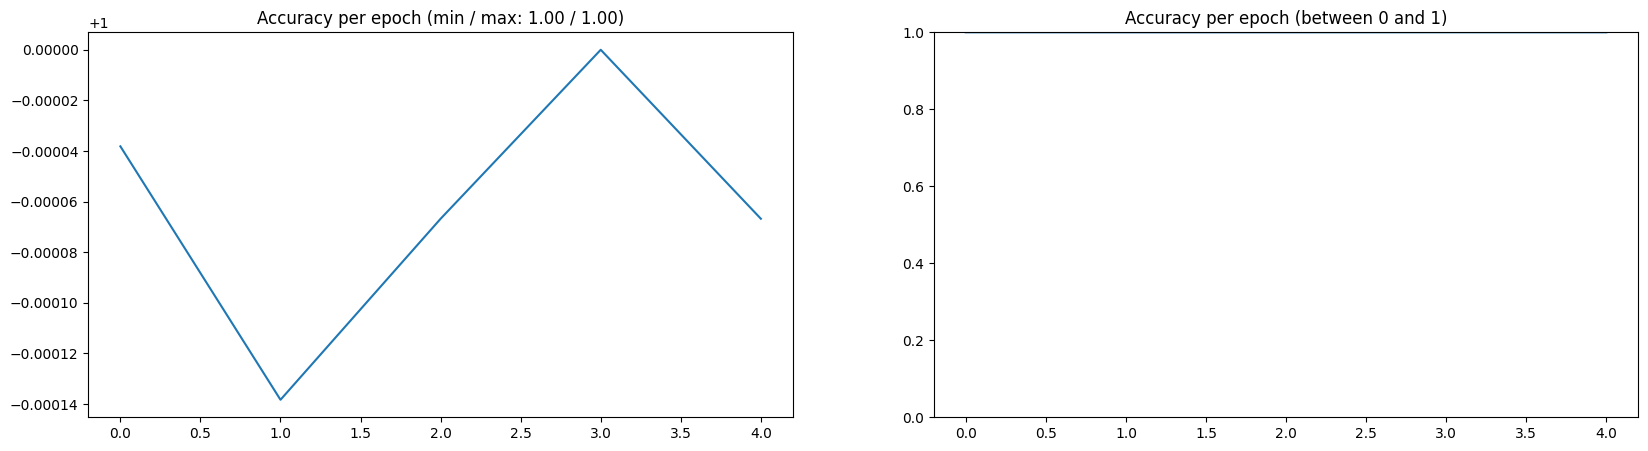

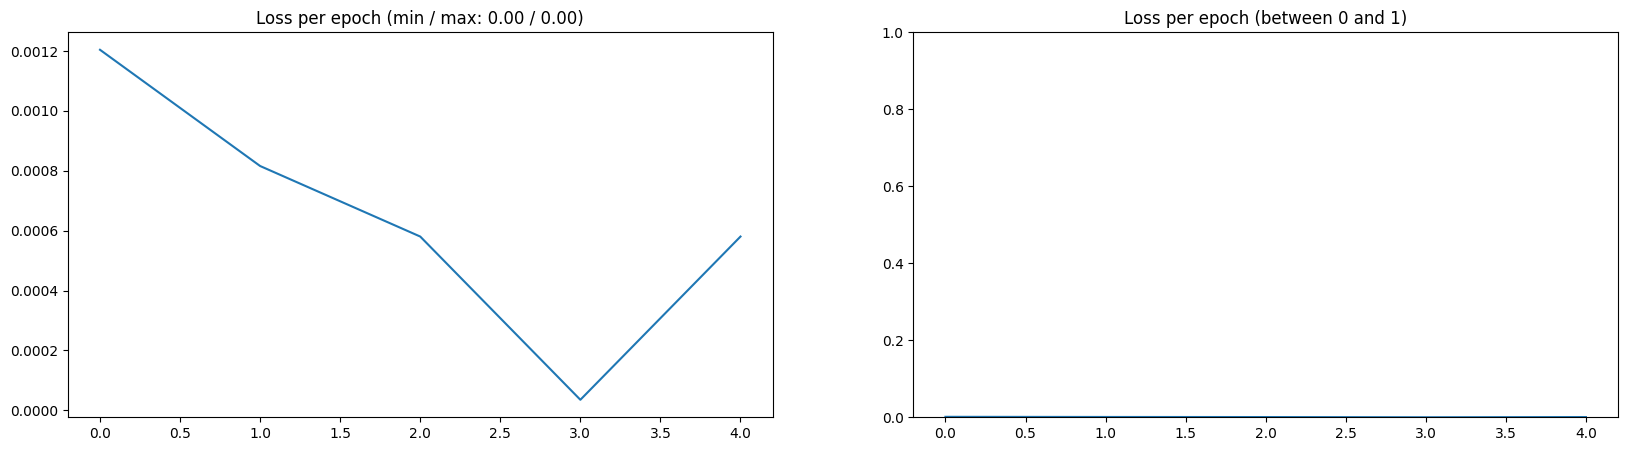

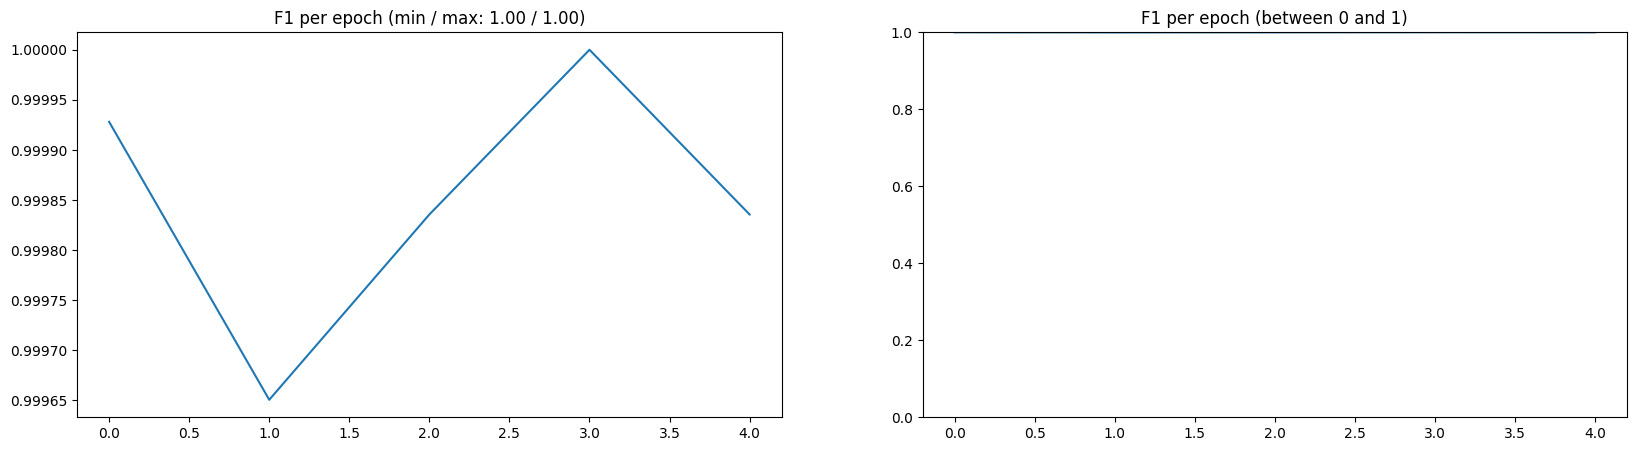

In [40]:
import matplotlib.pyplot as plt

metrics = {
    'eval_accuracy': 'Accuracy',
    'eval_loss': 'Loss',
    'eval_f1': 'F1',
}

for metric, title in metrics.items():

    points = []

    for epoch in trainer.state.log_history:
        if metric in epoch.keys():
            points.append(epoch[metric])

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(points)
    plt.title(f"{title} per epoch (min / max: {min(points):.2f} / {max(points):.2f})")

    plt.subplot(1, 2, 2)
    plt.plot(points)
    plt.ylim(0, 1)
    plt.title(f"{title} per epoch (between 0 and 1)")

    plt.show()


In [41]:
def gather_outputs(outputs: list) -> list:
    # Group entities by their sequence
    grouped_entities = []
    current_group = []
    for entity in outputs:
        if not current_group or entity['start'] == current_group[-1]['end']:
            current_group.append(entity)
        else:
            grouped_entities.append(current_group)
            current_group = [entity]
    
    # Append the last group
    if current_group:
        grouped_entities.append(current_group)
    
    return grouped_entities

def get_locations_from_outputs(sentence: str, outputs: list) -> list:
    groups = gather_outputs(outputs)
    groups = [{"group": group[0]["entity_group"], "city": sentence[group[0]["start"]:group[-1]["end"]] } for group in groups]
    
    # if there is more than one of the same entity group, return groups
    if len(set([group["group"] for group in groups])) != len(groups):
        return groups
    
    return sorted(groups, key=lambda group: group["group"], reverse=True)

In [42]:
from transformers import pipeline
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je vais de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve-moi un itinéraire pour aller à Besançon depuis la ville d'Oyonnax.",
    "Ca met combien de temps un Toulouse Paris ?",
    "C'est quoi le trajet de Troyes à Niort ?",
    "Comment aller à Niort depuis Troyes ?",
    "Comment aller à Niort depuis Troyes",
    "Recherche un itinéraire de Nantes à Paris où habite Théo",
    "Trouve-moi le chemin le plus rapide vers Paris depuis Nantes pour arriver chez Michel.",
    "Il y a-t-il des trains de Nantes à Montaigu"
]

for sentence in sentences:
    token_classifier = pipeline("token-classification", model="models/camembert-finetuned-token-classification-ner-trip", aggregation_strategy="simple")
    outputs = token_classifier(sentence)
    print(get_locations_from_outputs(sentence, outputs))

[{'group': 'DEP', 'city': 'Port-Boulet'}, {'group': 'ARR', 'city': 'Le Havre'}]
[{'group': 'DEP', 'city': 'Port-Boulet'}, {'group': 'ARR', 'city': 'Le Havre'}]
[{'group': 'DEP', 'city': 'Épierre'}, {'group': 'ARR', 'city': 'Paris'}]
[{'group': 'DEP', 'city': 'Margny-Lès-Compiègne'}, {'group': 'ARR', 'city': 'Saarbrücken /Sarrebruck'}]
[{'group': 'DEP', 'city': 'Nantes.'}, {'group': 'ARR', 'city': 'Saint-Étienne'}]
[{'group': 'DEP', 'city': 'Marseille'}, {'group': 'ARR', 'city': 'Tours'}]
[{'group': 'DEP', 'city': 'Lorient'}, {'group': 'ARR', 'city': 'Paris'}]
[{'group': 'DEP', 'city': 'Oyonnax.'}, {'group': 'ARR', 'city': 'Besançon'}]
[{'group': 'DEP', 'city': 'Toulouse'}, {'group': 'ARR', 'city': 'Paris'}]
[{'group': 'DEP', 'city': 'Troyes'}, {'group': 'ARR', 'city': 'Niort'}]
[{'group': 'DEP', 'city': 'Troyes'}, {'group': 'ARR', 'city': 'Niort'}]
[{'group': 'DEP', 'city': 'Troyes'}, {'group': 'ARR', 'city': 'Niort'}]
[{'group': 'DEP', 'city': 'Nantes'}, {'group': 'ARR', 'city': 'Pari